In [1]:
# 모듈 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2, os
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold

In [2]:
# 상수 정의
dataset_path = "E:\\AI_data\\training_set"

str2label = { "bird" : 0,
              "car" : 1,
              "cat" : 2,
              "dog" : 3,
              "fish" : 4 }

In [3]:
# 데이터셋 정의
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.float()
        self.labels = labels.float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [4]:
# 데이터셋 처리 함수 정의
def path2tensor(path, label):
    data_x = []
    data_y = []
    
    files = os.listdir(path)
    for f in files:
        f = os.path.join(path, f)
        img = cv2.imread(f).astype(np.float32) / 255
        img = np.transpose(img, (2, 0, 1))
        data_x.append(img)

        y = [0 for i in range(5)]
        y[label] = 1
        data_y.append(y)

    return (data_x, data_y)

In [5]:
data_x = []
data_y = []

for c in ["bird", "car", "cat", "dog", "fish"]:
    result = path2tensor(os.path.join(dataset_path, c), str2label[c])
    data_x += result[0]
    data_y += result[1]

data_x = np.array(data_x)
data_y = np.array(data_y)

In [6]:
data_x.shape

(13980, 3, 128, 128)

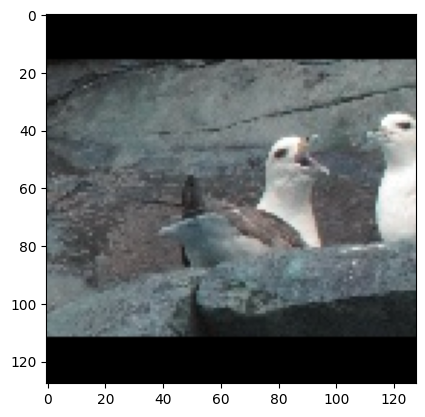

In [7]:
import matplotlib.pyplot as plt
show_img = np.squeeze(data_x[0])  # 배치 차원 제거
plt.imshow(np.transpose(show_img, (1, 2, 0)))  # CHW -> HWC로 변환하여 표시

In [8]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim

In [9]:
# 신경망 정의
class Res18Net(nn.Module):
    def __init__(self):
        super(Res18Net, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
# min loss version #

"""import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

num_epochs = 200

patience = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

x_train = torch.tensor(data_x, dtype=torch.float32)
y_train = torch.tensor(data_y, dtype=torch.float32)

train_dataset = MyDataset(x_train, y_train)

dataset_size = len(train_dataset)
labels = y_train.numpy()

train_indices, val_indices = train_test_split(
    range(dataset_size),
    test_size=0.15,
    stratify=labels,
    random_state=42
)

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=32, shuffle=False)

model = Res18Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

min_loss = None

val_loss = []
val_acc = []
val_f1 = []
train_loss = []

no_progress = 0

# 훈련 루프
for epoch in tqdm(range(num_epochs)):
    model.model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(total_train_loss / len(train_loader))

    # 검증 루프
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss.append(avg_val_loss)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracy = (all_preds == all_targets).mean()
    val_acc.append(accuracy)

    f1 = f1_score(all_targets, all_preds, average='weighted')
    val_f1.append(f1)

    if not min_loss:
        min_loss = avg_val_loss

    if min_loss > avg_val_loss:
        no_progress = 0
        min_loss = avg_val_loss
        torch.save(model.state_dict(), f"v1_{epoch}.wgt")
        print(f"model saved! (val_loss: {avg_val_loss})")
    else:
        no_progress += 1

    if no_progress > patience:
        print(f"no progress during {patience} epochs!")
        break"""

In [11]:
# max acc version #
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

num_epochs = 200

patience = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

x_train = torch.tensor(data_x, dtype=torch.float32)
y_train = torch.tensor(data_y, dtype=torch.float32)

train_dataset = MyDataset(x_train, y_train)

dataset_size = len(train_dataset)
labels = y_train.numpy()

train_indices, val_indices = train_test_split(
    range(dataset_size),
    test_size=0.15,
    stratify=labels,
    random_state=42
)

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=32, shuffle=False)

model = Res18Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

max_acc = None

val_loss = []
val_acc = []
val_f1 = []
train_loss = []

no_progress = 0

# 훈련 루프
for epoch in tqdm(range(num_epochs)):
    model.model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(total_train_loss / len(train_loader))

    # 검증 루프
    model.eval()
    total_val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss.append(avg_val_loss)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracy = (all_preds == all_targets).mean()
    val_acc.append(accuracy)

    f1 = f1_score(all_targets, all_preds, average='weighted')
    val_f1.append(f1)

    if not max_acc:
        max_acc = accuracy

    if max_acc < accuracy:
        no_progress = 0
        max_acc = accuracy
        torch.save(model.state_dict(), f"v1_{epoch}.wgt")
        print(f"model saved! (val_acc: {max_acc})")
    else:
        no_progress += 1

    if no_progress > patience:
        print(f"no progress during {patience} epochs!")
        break

Using device: cuda


  1%|▊                                                                               | 2/200 [00:48<1:20:39, 24.44s/it]

model saved! (val_acc: 0.9535526943252265)


  2%|█▏                                                                              | 3/200 [01:13<1:20:09, 24.41s/it]

model saved! (val_acc: 0.9546018121125417)


  2%|█▌                                                                              | 4/200 [01:37<1:19:41, 24.39s/it]

model saved! (val_acc: 0.962899380066762)


  4%|███▌                                                                            | 9/200 [03:39<1:17:29, 24.34s/it]

model saved! (val_acc: 0.9675727229375298)


  6%|█████▏                                                                         | 13/200 [05:16<1:15:50, 24.34s/it]

model saved! (val_acc: 0.9703385789222699)


 10%|███████▌                                                                       | 19/200 [07:42<1:13:24, 24.33s/it]

model saved! (val_acc: 0.971864568431092)


 20%|███████████████▍                                                               | 39/200 [16:13<1:06:57, 24.96s/it]

no progress during 20 epochs!


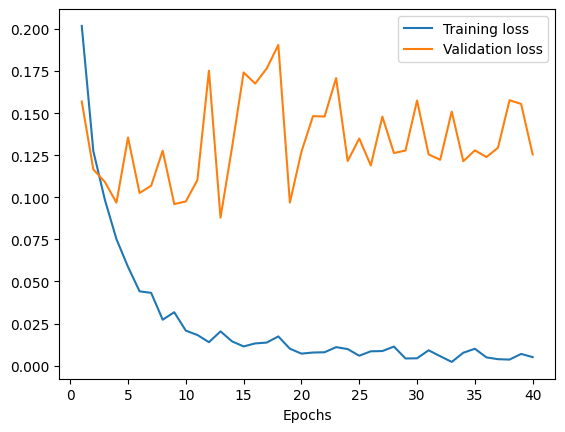

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_loss)+1), train_loss, label='Training loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation loss')

plt.xlabel("Epochs")
plt.legend()
plt.show()

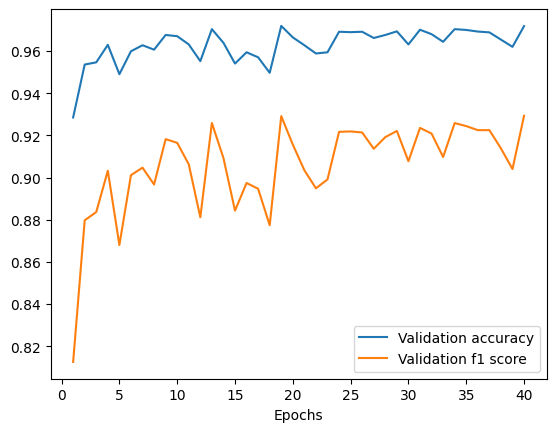

In [13]:
plt.cla()

plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.plot(range(1, len(val_acc)+1), val_f1, label='Validation f1 score')

plt.xlabel("Epochs")
plt.legend()
plt.show()